In [1]:
# Boilerplate
%matplotlib inline

# Intel DAAL related imports
from daal.data_management import HomogenNumericTable

# Helpersfor getArrayFromNT and printNT. See utils.py
from utils import *

# Import numpy, matplotlib, seaborn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Plotting configurations
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (12, 9)

# Clustering with K-Means

### Tutorial brief 
This tutorial consists of two parts. Firstly, we walk through an example of using the K-Means form pyDAAL for clustering the Iris dataset. Secondly, we try K-Means for a dataset with a much higher dimensionality (90 features). We reduce the dimensionality to 2 before clustering, such that the clusters can be easily visualized. We use PCA for dimensionality reduction. The K-Means code is provided. The PCA code is left as an exercise. 

### Learning objectives 
* To get familiar with pyDAAL API look-and-feel.
* To understand and practice the typical code sequence of using pyDAAL for unsupervised learning.

### K-Means introduction 
K-Means is a commonly used clustering algorithm. It takes input data and a given number of clusters $k$, then iteratively computes $k$ centroids for $k$ clusters, and assigns observations in the input dataset to these clusters. The algorithm minimizes the within-cluster sum of distances between observations and cluster centroids. This is called the goal function:
$$\sum\limits_{i=1}^{k} \sum\limits_{j:x_j\in S_i}^n\|x_j-m_i\|^2$$
Here, $k$ is the number of clusters, $n$ is the number of observations, $S_i$ is the $i$-th cluster with $m_i$ as its centroid, $x_j$ is the $j$-th observation.

### PCA introduction 
Principal Component Analysis (PCA) is a commonly used technique for dimensionality reduction. The algorithm computes $p$ eigenvalues and $p$ eigenvectors from the correlation matrix of the input data, where $p$ is the number of features. Multiplying the largest $d$ eigenvectors (according to the eigenvalues) to the input data gives a reduced dataset with $d$ dimensions ($d < p$). 

### The Iris dataset 
We use the Iris dataset from `sklearn.datasets`. The code below loads the data and displays some basic information of it.

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
print('Shape:', iris.data.shape)
print('Features:', iris.feature_names)
print('Labels: ', iris.target_names)

Shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Labels:  ['setosa' 'versicolor' 'virginica']


### K-Means code using pyDAAL 
The code below defines `class KMeans`, which encapsulates the K-Means algorithm from pyDAAL. The implementation is in the `compute` method. Note that there are 2 steps. The initialization step is to randomly pick $k$ centroids. The clustering step runs up to `maxiter` iterations: Each iteration assign each of all observations to the closest centroid, and then re-computes the centroids. The code returns 4 pieces of results: `centroids`, `assignments`, `goalFunction`, and `niterations`.

In [3]:
import daal.algorithms.kmeans as kmeans
from daal.algorithms.kmeans import init


class KMeans:

    def __init__(self, nclusters, randomseed = None):
        """Initialize class parameters
        
        Args:
           nclusters: Number of clusters
           randomseed: An integer used to seed the random number generator
        """

        self.nclusters_ = nclusters
        self.seed_ = 1234 if randomseed is None else randomseed
        self.centroids_ = None
        self.assignments_ = None
        self.goalfunction_ = None
        self.niterations_ = None


    def compute(self, data, centroids = None, maxiters = 100):
        """Compute K-Means clustering for the input data

        Args:
           data: Input data to be clustered
           centroids: User defined input centroids. If None then initial
               centroids will be randomly chosen
           maxiters: The maximum number of iterations
        """

        if centroids is None:
            # Create an algorithm object for centroids initialization
            init_alg = init.Batch_Float64RandomDense(self.nclusters_)
            # Set input
            init_alg.input.set(init.data, data)
            # Set parameters
            init_alg.parameter.seed = self.seed_
            # Compute initial centroids
            self.centroids_ = init_alg.compute().get(init.centroids)
        else:
            self.centroids_ = centroids

        # Create an algorithm object for clustering
        clustering_alg = kmeans.Batch_Float64LloydDense(
                self.nclusters_,
                maxiters)
        # Set input
        clustering_alg.input.set(kmeans.data, data)
        clustering_alg.input.set(kmeans.inputCentroids, self.centroids_)
        # compute
        result = clustering_alg.compute()
        self.centroids_ = result.get(kmeans.centroids)
        self.assignments_ = result.get(kmeans.assignments)
        self.goalfunction_ = result.get(kmeans.goalFunction)
        self.niterations_ = result.get(kmeans.nIterations)
    

### Clustering and visualization 
We now apply K-Means to the Iris dataset. A few things to note:
* The original input data is an ndarray. We need to convert it to a DAAL NumericTable. 
* The number of clusters is set to 3 because there're 3 types of Iris in the data. 
* We want to visualize the clustering, so we get `assignments` from the results, which is a NumericTable. We convert it back to an ndarray so it can be passed into the plotting function.
* Although there are 4 dimensions in the data (see `iris.feature_names` above), we arbitrarily choose 3 ('Petal width', 'Sepal length', and 'Petal length') to create a 3D plot.
* On the 3D plot, data points are colored according to their assigned labels. This allows us to see the clusters. 

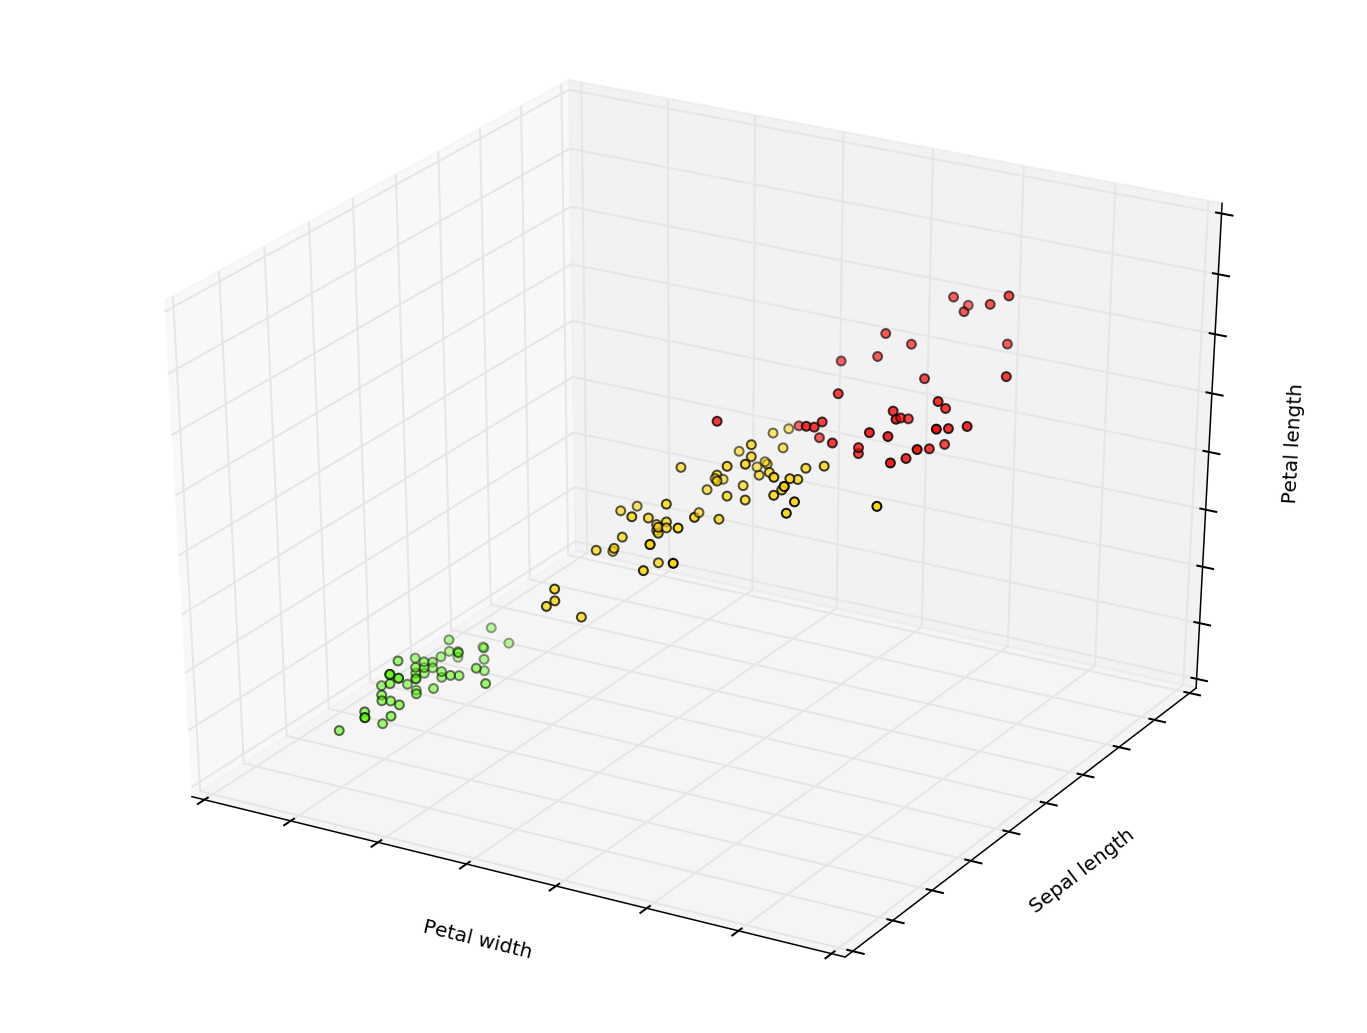

In [21]:
# Create a NumericTable from the Iris dataframe
iris_data = HomogenNumericTable(iris.data.astype(dtype=np.double))

# The number of clusters is 3, as there're 3 labels
nclusters = len(np.unique(iris.target))

# K-Means clustering
clustering = KMeans(nclusters)
clustering.compute(iris_data)
assignments = getArrayFromNT(clustering.assignments_).flatten().astype(np.int)

# Visualize 3 clusters using a 3D plot
from mpl_toolkits.mplot3d import Axes3D

plt.set_cmap(plt.cm.prism)
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(iris.data[:, 3], iris.data[:, 0], iris.data[:, 2], c=assignments)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.show()

### Exercise: Clustering for a high-dimensional dataset
In this section we take a look at the [Libras Movement Dataset](http://archive.ics.uci.edu/ml/datasets/Libras+Movement) from the UCI machine learning repository.

The data has been pre-downloaded in the './mldata' folder, and can be loaded into memory using `np.genfromtxt("./mldata/movement_libras.data", ...)`.

According to the dataset description:
>--- LIBRAS, acronym of the Portuguese name "LIngua BRAsileira de Sinais", is the oficial brazilian sign language.

>--- The dataset (movement_libras) contains 15 classes of 24 instances each, where each class references to a hand 
>       movement type in LIBRAS. The hand movement is represented as a bidimensional curve performed by the hand in a 
>       period of time. The curves were obtained from videos of hand movements, with the Libras performance from 4 
>       different people, during 2 sessions. Each video corresponds to only one hand movement and has about 7 seconds. 

The number of features of the data is 90, corresponding to columns 0 through 89 in the input. The last column (90) is the class labels. For cluster analysis, we could have applied K-Means the same way we did in the previous section. However, it will be very difficult, if not impossible, to visualize it. In this section, you are asked to implement a PCA class using pyDAAL. After that, we use the the PCA to reduce the dimensionality to 2. We apply K-Means to the reduced dataset. And then we can visualize the clustering with a 2D plot.

The skeleton of the PCA class code is given below. Please provide an implementation for the **`compute`** method.

In [5]:
import daal.algorithms.pca as pca

class PCA:

    def __init__(self, method = 'correlation'):
        """Initialize class parameters

        Args:
           method: The default method is based on correation matrix. It
           can also be the SVD method ('svd')
        """

        if method != 'correlation' and method != 'svd':
            warnings.warn(method + 
            ' method is not supported. Default method is used', 
            UserWarning)

        self.method_ = method
        self.eigenvalues_ = None
        self.eigenvectors_ = None


    def compute(self, data):
        """Compute PCA the input data

        Args:
           data: Input data 
        """
               
        # Create an algorithm object for PCA
        #
        # YOUR CODE HERE
        # The algorithm class you need is either Batch_Float64SvdDense or Batch_Float64CorrelationDense.

        # Set input
        #
        # YOUR CODE HERE
        # Use the 'input.setDataSet' member method of the algorithm class to set input. 
        # Th signature of the method is: input.setDataset(InputID, input)
        # You should use 'pca.data' for InputID.
        
        # compute
        #
        # YOUR CODE HERE
        # You should store the return value of compute to 'result'
        
        self.eigenvalues_ = result.get(pca.eigenvalues)
        self.eigenvectors_ = result.get(pca.eigenvectors)


Now that the PCA class is implemented. We can use it for dimensionality reduction. The `eigenvectors` from PCA result contains $p$ eigenvectors in the row major order and sorted from the largest to the smallest. In this case, we take the first (largest) two eigenvectors and multiply them with the original data using NumPy's `dot` function. This gives us a reduced dataset with 2 columns. The number of rows doesn't change.

Next, apply pyDAAL KMeans on the reduced data. Assignments (labels) and the final centroids are retrieved from the result for visualization (see below).

In [18]:
#from pca import *

# Load data from the CSV file
tra = np.genfromtxt('./mldata/movement_libras.data', dtype = np.double, delimiter=',', usecols=list(range(90)))

# Create a NumericTable
tra_data = HomogenNumericTable(tra)

# Dimensionality reduction
pr = PCA(method='svd')
pr.compute(tra_data)
loadings = getArrayFromNT(pr.eigenvectors_)

# Multiply the largest 2 eigenvectors with the original data
tra_reduced = np.dot(tra, loadings[:2].T)
tra_reduced_data = HomogenNumericTable(tra_reduced)

# K-Means clustering on the reduced dataset
nclusters = 15
clustering = KMeans(nclusters)
clustering.compute(tra_reduced_data, maxiters=1000)
assignments = getArrayFromNT(clustering.assignments_).flatten().astype(np.int)
centroids = getArrayFromNT(clustering.centroids_)

The code below creates a 2D plot to show the 10 clusters. Each sample is colored according to the assigned label. The centroids of the clusters are shown as big black x's on the plot.

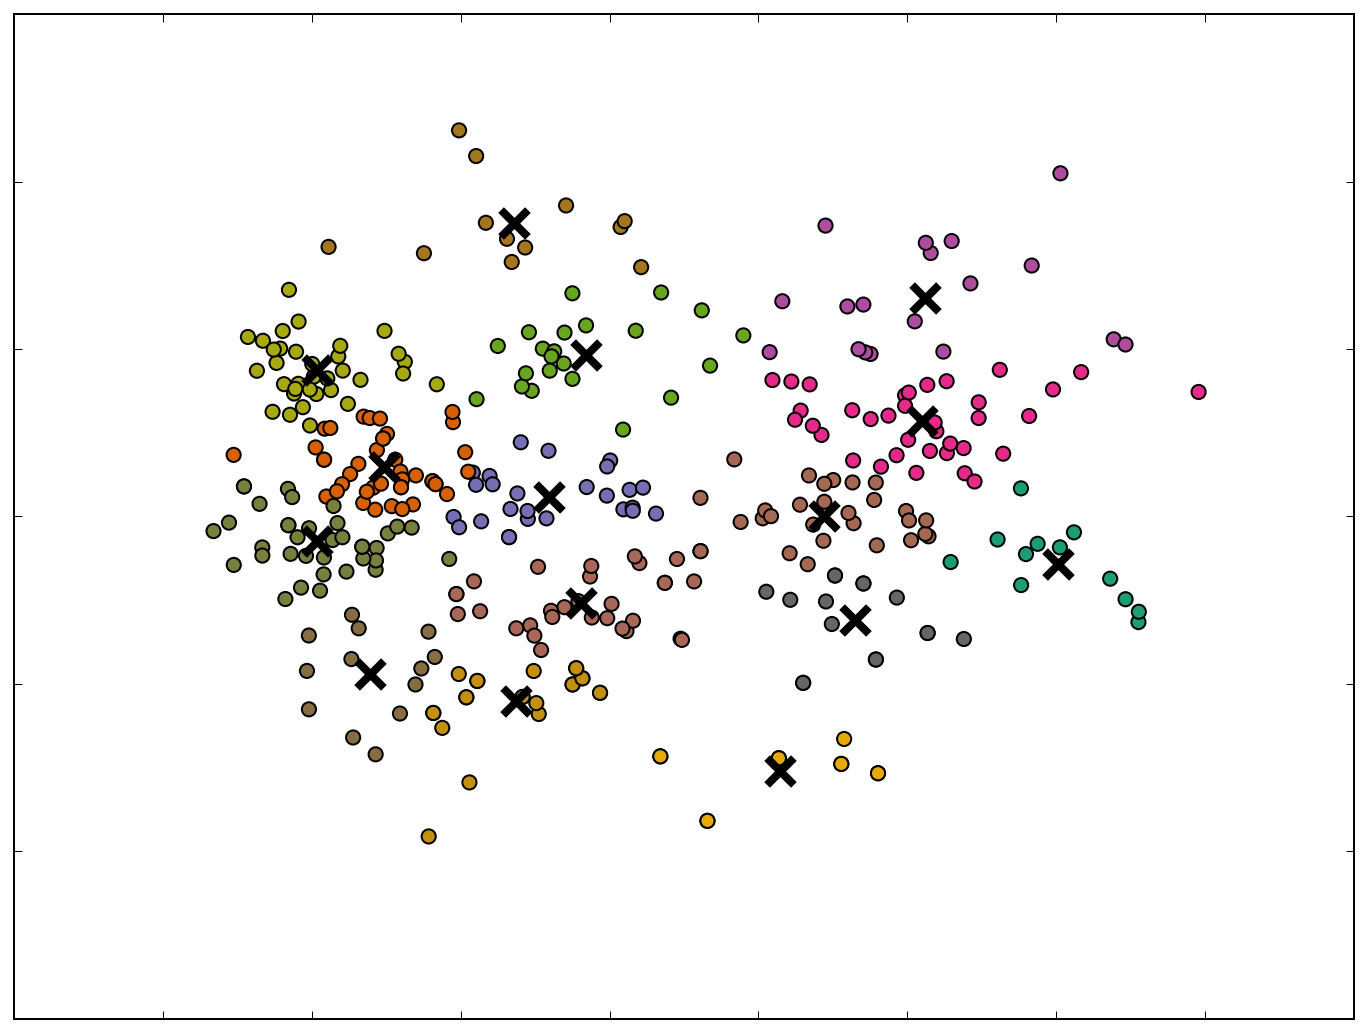

In [20]:
plt.set_cmap(plt.cm.Dark2)
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(tra_reduced[:, 0], tra_reduced[:, 1], s=50, c=assignments)
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=180, linewidths=4, color='black')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.show()

### Summary

In this lab, we learned two unsupervised learning algorithms: K-Means clustering and PCA. We saw how to apply them to cluster and visualize the handwritten digits dataset. We studied and practiced pyDAAL API for these two algorithms.